In [1]:
!pip install -U -q torch_snippets
!pip install torchsummary
from torch_snippets import *

     |████████████████████████████████| 41 kB 375 kB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 58 kB 3.2 MB/s 
     |████████████████████████████████| 10.9 MB 46.1 MB/s 
     |████████████████████████████████| 217 kB 16.3 MB/s 
     |████████████████████████████████| 51 kB 3.5 MB/s 


In [2]:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import  models, datasets
from torchvision import transforms as T
from torchsummary import summary
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1.Prepare Dataset

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [4]:
!kaggle datasets download -d drgfreeman/rockpaperscissors
!mkdir rockpaperscissors
!unzip -q rockpaperscissors.zip -d rockpaperscissors
!rm rockpaperscissors.zip
!rm -r /content/rockpaperscissors/rps-cv-images

100% 306M/306M [00:11<00:00, 36.9MB/s]



In [5]:
import random
imgs = glob.glob('/content/rockpaperscissors/*/*')
random.shuffle(imgs)

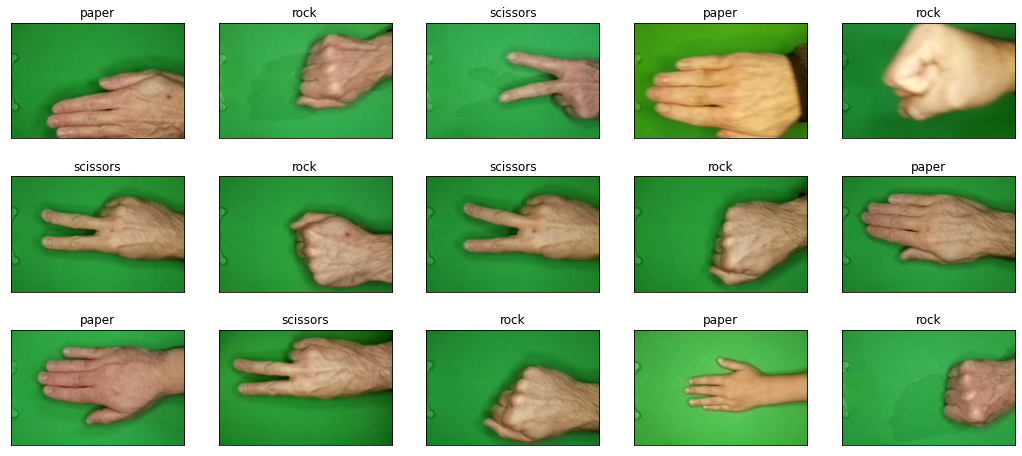

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,8))

for i, x in enumerate(axes.flatten()):
  img = cv2.imread(imgs[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  x.imshow(img)
  x.set_title(imgs[i].split('/')[-2])
  x.get_xaxis().set_visible(False)
  x.get_yaxis().set_visible(False)

In [7]:
class RockPaperScissorsDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
      return len(self.df)

  def __getitem__(self, index):
    data = self.df.iloc[index]
    img = cv2.imread(data['images'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cls = data['class_index']
    return img, cls

  def collate_fn(self, batch):
    imgs, classes = list(zip(*batch))
    if self.transform:
      imgs =[self.transform(img)[None] for img in imgs]
    classes = [torch.tensor([cls]) for cls in classes]
    imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    return imgs, classes

In [8]:
train_transform = T.Compose([
                            T.ToPILImage(),
                            T.Resize(200),
                            T.ColorJitter(brightness=(0.8,1.2),
                                          contrast=(0.8,1.2),
                                          saturation=(0.8,1.2),
                                          hue=0.25),
                            T.RandomRotation(degrees=(0, 180)),
                            T.ToTensor(),
                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

val_transform = T.Compose([
                           T.ToPILImage(),
                           T.Resize(200),
                           T.ToTensor(),
                           T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
cls_dict = {
    'paper'   : 0,
    'rock'    : 1,
    'scissors': 2
}

data = glob.glob('/content/rockpaperscissors/*/*')
data = pd.DataFrame(data, columns=['images'])
data['class'] = data['images'].str.split('/').str[-2]
data['class_index'] = data['class'].map(cls_dict)
data.head()

,images,class,class_index
0,/content/rockpaperscissors/scissors/dFlxUAypUg...,scissors,2
1,/content/rockpaperscissors/scissors/FoYWUBXBw6...,scissors,2
2,/content/rockpaperscissors/scissors/eCrwTPFv8g...,scissors,2
3,/content/rockpaperscissors/scissors/GGQjHIWNHM...,scissors,2
4,/content/rockpaperscissors/scissors/VRUsuwjXjZ...,scissors,2


In [10]:
train_data, val_data = train_test_split(data, test_size=.2, stratify=data['class'], random_state=42)
train_data.shape, val_data.shape

((1750, 3), (438, 3))

In [11]:
train_dataset = RockPaperScissorsDataset(train_data, transform=train_transform)
val_dataset  = RockPaperScissorsDataset(val_data, transform=val_transform)
train_loader  = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=train_dataset.collate_fn)
val_loader    = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=val_dataset.collate_fn)

In [12]:
testing = next(iter(train_loader))
testing[0].shape, testing[1].shape

(torch.Size([32, 3, 200, 300]), torch.Size([32]))

# 2. Membuat model

In [18]:
def get_model():
  def conv_layer(in_channel, out_channel, kernel_size=3, stride=1, padding=0):
    return nn.Sequential(
                          nn.Conv2d(in_channel, out_channel, kernel_size=kernel_size, stride=stride, padding=padding),
                          nn.ReLU(),
                          nn.BatchNorm2d(out_channel),
                          nn.MaxPool2d(2)
    )

  model = nn.Sequential(
                         conv_layer(3, 64),
                         conv_layer(64, 128),
                         conv_layer(128, 256),
                         conv_layer(256, 512),
                         nn.AdaptiveAvgPool2d((2, 2)),
                         nn.Flatten(),
                         nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Linear(512, 128),
                         nn.ReLU(),
                         nn.Linear(128, 3)
  )

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, loss_fn, optimizer

Test

In [21]:
model, loss_fn, optimizer = get_model()
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [23]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  imgs, labels = data
  ypreds = model(imgs)
  optimizer.zero_grad()
  loss = criterion(ypreds, labels)
  loss.backward()
  optimizer.step()
  acc = (torch.max(ypreds, 1)[1]==labels).float().mean()
  return loss.item(), acc.item()

def val_batch(model, data, criterion):
  model.eval()
  imgs, labels = data
  ypreds = model(imgs)
  loss = criterion(ypreds, labels)
  acc = (torch.max(ypreds, 1)[1]==labels).float().mean()
  return loss.item(), acc.item()

In [24]:
model, loss_fn, optimizer = get_model()
model.to(device)
n_epochs = 50
log = Report(n_epochs)

for i in range(n_epochs):
  N = len(train_loader)
  for j, data in enumerate(train_loader):
    loss, acc = train_batch(model, data, optimizer, loss_fn)
    log.record(i+(j+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_loader)
  for j, data in enumerate(val_loader):
    loss, acc = val_batch(model, data, loss_fn)
    log.record(i+(j+1)/N, val_loss=loss, val_acc=acc, end='\r')

  log.report_avgs(i+1)

EPOCH: 1.000	trn_loss: 1.481	trn_acc: 0.351	val_loss: 1.086	val_acc: 0.424	(33.35s - 1634.15s remaining)
EPOCH: 2.000	trn_loss: 1.063	trn_acc: 0.444	val_loss: 0.911	val_acc: 0.550	(64.61s - 1550.60s remaining)
EPOCH: 3.000	trn_loss: 1.021	trn_acc: 0.450	val_loss: 0.960	val_acc: 0.555	(96.63s - 1513.92s remaining)
EPOCH: 4.000	trn_loss: 0.971	trn_acc: 0.490	val_loss: 0.962	val_acc: 0.562	(128.31s - 1475.53s remaining)
EPOCH: 5.000	trn_loss: 0.917	trn_acc: 0.523	val_loss: 0.889	val_acc: 0.587	(159.54s - 1435.88s remaining)
EPOCH: 6.000	trn_loss: 0.883	trn_acc: 0.562	val_loss: 1.167	val_acc: 0.495	(190.76s - 1398.92s remaining)
EPOCH: 7.000	trn_loss: 0.880	trn_acc: 0.586	val_loss: 0.932	val_acc: 0.529	(222.26s - 1365.29s remaining)
EPOCH: 8.000	trn_loss: 0.836	trn_acc: 0.622	val_loss: 0.951	val_acc: 0.500	(254.07s - 1333.89s remaining)
EPOCH: 9.000	trn_loss: 0.693	trn_acc: 0.715	val_loss: 0.802	val_acc: 0.663	(285.39s - 1300.11s remaining)
EPOCH: 10.000	trn_loss: 0.570	trn_acc: 0.802	val_

100%|██████████| 151/151 [00:00<00:00, 447.53it/s]


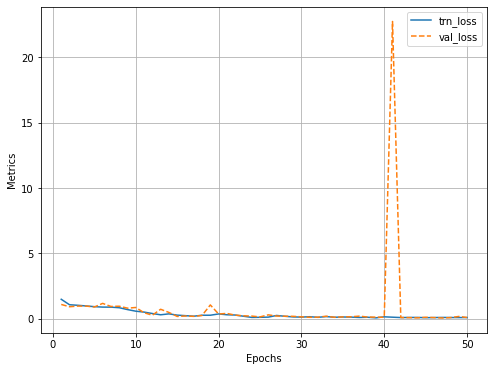

In [25]:
log.plot_epochs('trn_loss,val_loss'.split(','))

100%|██████████| 151/151 [00:00<00:00, 552.15it/s]


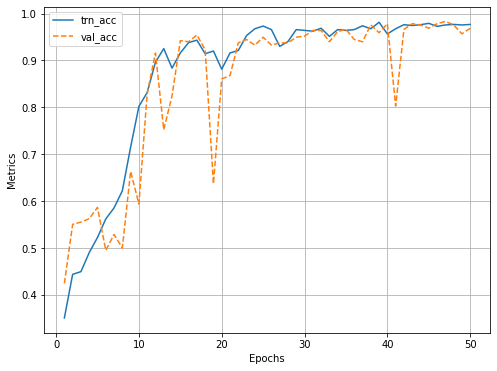

In [26]:
log.plot_epochs('trn_acc,val_acc'.split(','))

In [27]:
log.report_avgs(50)

EPOCH: 50.000	trn_loss: 0.083	trn_acc: 0.977	val_loss: 0.087	val_acc: 0.969	(1736.38s - 0.00s remaining)
